In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-12-25 12:51:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 142.250.136.207, 142.250.148.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: 'pizza_steak.zip'

pizza_steak.zip     100%[===================>] 104.47M   212MB/s    in 0.5s    

2023-12-25 12:51:32 (212 MB/s) - 'pizza_steak.zip' saved [109540975/109540975]



**Unzip the Dowloaded Data:**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

**Check for the directories and their contents:**

In [3]:
import os
for dirpath, dirnames, filenames in os.walk('/kaggle/working/pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /kaggle/working/pizza_steak
There are 2 directories and 0 images in /kaggle/working/pizza_steak/test
There are 0 directories and 250 images in /kaggle/working/pizza_steak/test/steak
There are 0 directories and 250 images in /kaggle/working/pizza_steak/test/pizza
There are 2 directories and 0 images in /kaggle/working/pizza_steak/train
There are 0 directories and 750 images in /kaggle/working/pizza_steak/train/steak
There are 0 directories and 750 images in /kaggle/working/pizza_steak/train/pizza


**Check for the class names we are working with:**

In [4]:
import pathlib
import numpy as np
data_dir = pathlib.Path('/kaggle/working/pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


**Create a function to view random training images of different classes we are working with:**

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
        target_folder = target_dir + '/' + target_class
        random_image = random.sample(os.listdir(target_folder), 1)
        img = mpimg.imread(target_folder + '/' + random_image[0])
        plt.imshow(img)
        plt.title(target_class)
        plt.axis(False)

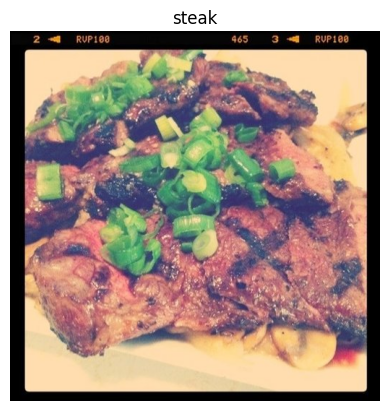

In [6]:
view_random_image('/kaggle/working/pizza_steak/train', 'steak')

**Preprocess our data by Scaling, Data Augmentation, creating batches using flow_from_directory:**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/kaggle/working/pizza_steak/train'
test_dir = '/kaggle/working/pizza_steak/test'
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                            rotation_range = 20,
                                            shear_range = 0.2,
                                            zoom_range = 0.2,
                                            width_shift_range = 0.2,
                                            height_shift_range = 0.2,
                                            horizontal_flip =True)
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir, 
                                                                   batch_size = 32,
                                                                   target_size = (224, 224),
                                                                   shuffle = False,
                                                                   class_mode = 'binary',
                                                                   seed = 42)
train_data = train_datagen.flow_from_directory(train_dir, 
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               shuffle = False,
                                               class_mode = 'binary',
                                               seed = 42)
test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             target_size = (224, 224), 
                                             class_mode = 'binary',
                                             shuffle = True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**View Normal and Augmented Images:**

(-0.5, 223.5, 223.5, -0.5)

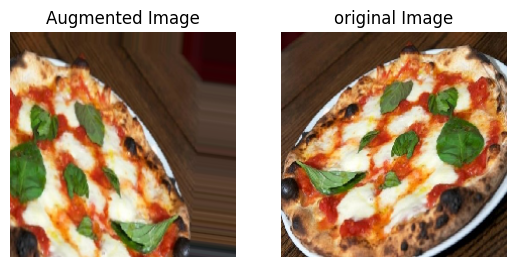

In [8]:
train_images_augmented, train_labels_augmented = train_data_augmented.next()
train_images, train_labels = train_data.next()
random_number = random.randint(0, 31)
plt.subplot(1, 2, 1)
plt.imshow(train_images_augmented[random_number])
plt.title('Augmented Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(train_images[random_number])
plt.title('original Image')
plt.axis('off')

In [9]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir, 
                                                                   batch_size = 32,
                                                                   target_size = (224, 224),
                                                                   shuffle = True,
                                                                   class_mode = 'binary',
                                                                   seed = 42)

Found 1500 images belonging to 2 classes.


**We gonna do various modelling experiments unless we found our required accuracy**
**Callbacks used : EarlyStopping and ReduceLROnPlateau**

**Model 1 using MaxPool2D:**

In [10]:
import tensorflow as tf
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
], name = 'model_1')
model_1.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_1 = model_1.fit(train_data_augmented_shuffled,
            epochs = 20,
            validation_data = test_data,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss', restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(patience = 3, monitor = 'val_loss', verbose = 1)])

Epoch 1/20
47/47 [==============================] - 35s 458ms/step - loss: 0.6569 - accuracy: 0.6380 - val_loss: 0.4842 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 19s 411ms/step - loss: 0.5288 - accuracy: 0.7507 - val_loss: 0.4036 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 19s 411ms/step - loss: 0.4886 - accuracy: 0.7713 - val_loss: 0.5088 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 19s 412ms/step - loss: 0.4908 - accuracy: 0.7687 - val_loss: 0.3371 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 19s 411ms/step - loss: 0.4465 - accuracy: 0.7953 - val_loss: 0.3127 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 20s 414ms/step - loss: 0.4589 - accuracy: 0.7927 - val_loss: 0.3880 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 19s 410ms/st

**Model 2 using AveargePooling2D:**

In [11]:
import tensorflow as tf
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.AveragePooling2D(pool_size = 2, padding = 'valid'),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(128, 3, activation = 'relu'),
    tf.keras.layers.AveragePooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
], name = 'model_2')
model_2.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_2 = model_2.fit(train_data_augmented_shuffled,
            epochs = 20,
            validation_data = test_data,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss', restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(patience = 3, monitor = 'val_loss', verbose = 1)])

Epoch 1/20
47/47 [==============================] - 44s 688ms/step - loss: 0.7055 - accuracy: 0.6513 - val_loss: 0.4504 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 21s 432ms/step - loss: 0.5783 - accuracy: 0.7093 - val_loss: 0.4218 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 21s 437ms/step - loss: 0.5237 - accuracy: 0.7540 - val_loss: 0.4020 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 21s 437ms/step - loss: 0.5096 - accuracy: 0.7527 - val_loss: 0.4371 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 21s 436ms/step - loss: 0.5068 - accuracy: 0.7533 - val_loss: 0.3863 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 21s 447ms/step - loss: 0.5015 - accuracy: 0.7687 - val_loss: 0.3709 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 21s 435ms/st

**create a function to create our model:**

In [12]:
efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'
import tensorflow_hub as hub
def create_model(model_url, num_classes):
    feature_extractor_layer = hub.KerasLayer(model_url, trainable = False, name = 'feature_extractor_layer', input_shape = (224, 224)+(3,))
    model = tf.keras.Sequential([
            feature_extractor_layer,
            tf.keras.layers.Dense(num_classes, activation = 'sigmoid')
    ])
    return model
        

**create a feature extractor model**

In [13]:
feature_extractor_model = create_model(model_url = efficientnet_url,
                                       num_classes = 1)
feature_extractor_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_3 = feature_extractor_model.fit(train_data_augmented_shuffled,
                            epochs = 20,
                            steps_per_epoch = len(train_data_augmented_shuffled),
                            validation_data = test_data,
                            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                          patience = 5, 
                                                                          restore_best_weights = True),
                                        tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1)])

Epoch 1/20
47/47 [==============================] - 28s 430ms/step - loss: 0.3909 - accuracy: 0.8887 - val_loss: 0.1600 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 20s 416ms/step - loss: 0.2138 - accuracy: 0.9473 - val_loss: 0.0949 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 20s 416ms/step - loss: 0.1769 - accuracy: 0.9547 - val_loss: 0.0719 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 19s 410ms/step - loss: 0.1539 - accuracy: 0.9500 - val_loss: 0.0609 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 19s 410ms/step - loss: 0.1410 - accuracy: 0.9520 - val_loss: 0.0530 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 19s 407ms/step - loss: 0.1338 - accuracy: 0.9553 - val_loss: 0.0482 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 19s 408ms/st

**Evaluate our three models on test data and find out best one**

In [14]:
model_1.evaluate(test_data)

16/16 [==============================] - 1s 76ms/step - loss: 0.2820 - accuracy: 0.8820


[0.2820415198802948, 0.8820000290870667]

In [15]:
model_2.evaluate(test_data)

16/16 [==============================] - 2s 100ms/step - loss: 0.2965 - accuracy: 0.8820


[0.29648512601852417, 0.8820000290870667]

In [16]:
feature_extractor_model.evaluate(test_data)

16/16 [==============================] - 1s 81ms/step - loss: 0.0318 - accuracy: 0.9900


[0.031762268394231796, 0.9900000095367432]

**Clearly feature_extractor_model's performance supasses the other two, so we would use it for our predictions:**

**Create a function to plot out model's performance:**

In [17]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(history.history['loss']))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.plot(epochs, loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

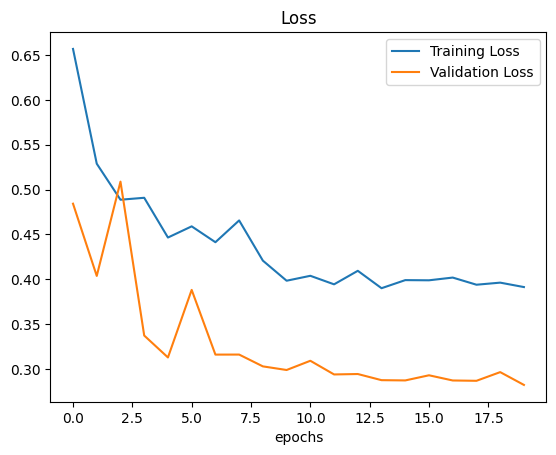

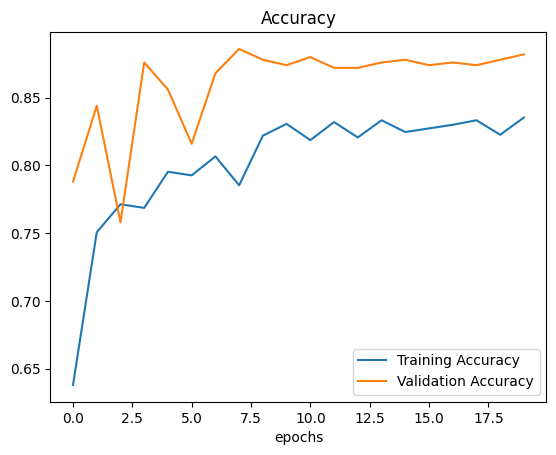

In [31]:
plot_loss_curves(history_1)

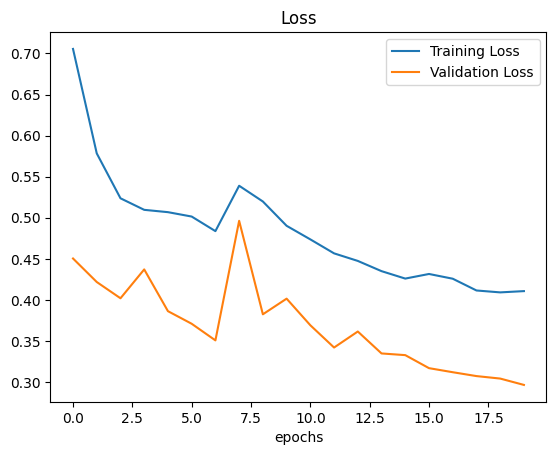

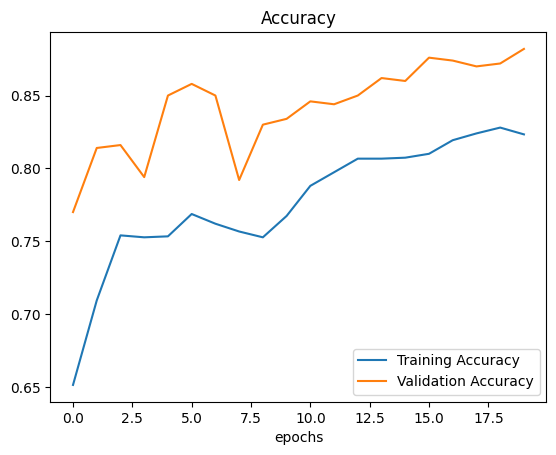

In [30]:
plot_loss_curves(history_2)

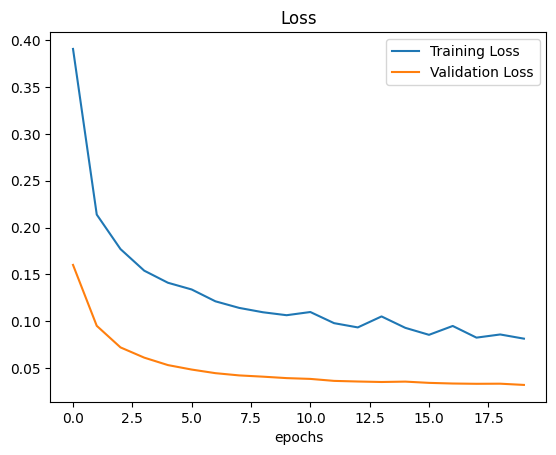

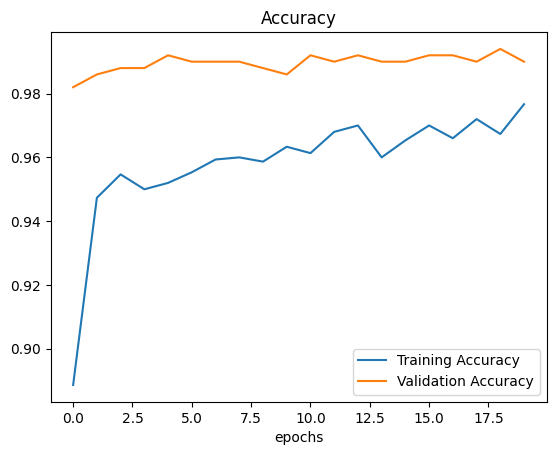

In [32]:
plot_loss_curves(history_3)

**Make predictions on the test data:**

In [18]:
feature_extractor_model_pred_probs = feature_extractor_model.predict(test_data)
feature_extractor_model_pred_probs[:10]

16/16 [==============================] - 2s 82ms/step


array([[9.9351114e-01],
       [9.5182841e-06],
       [2.6369495e-02],
       [6.6098779e-05],
       [5.7014043e-04],
       [5.1216230e-02],
       [2.8640701e-04],
       [4.1519240e-03],
       [8.3787483e-05],
       [4.7841469e-05]], dtype=float32)

In [19]:
feature_extractor_model_preds = tf.round(tf.squeeze(feature_extractor_model_pred_probs))
feature_extractor_model_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1.], dtype=float32)>

In [20]:
test_images, test_labels = test_data.next()
test_labels[:20]

array([0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 1.], dtype=float32)

**Model to prep the image we're goinn to test:**

In [21]:
def load_and_prep_image(filename, image_shape = 224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.resize(img, size = [image_shape, image_shape])
    img = img / 255.
    return img

**Pred and plot our model's prediction:**

In [22]:
def pred_and_plot(model, filename, class_name):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis = 0))
    pred_class = class_names[int(tf.round(pred))]
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

**Making predictions on the images from the wild**

1/1 [==============================] - 1s 1s/step


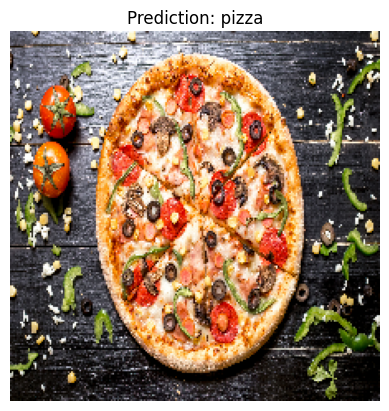

In [23]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-image/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden.jpg', class_names)

1/1 [==============================] - 0s 28ms/step


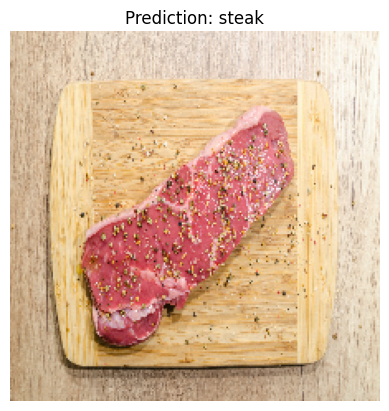

In [24]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-image-2/pexels-lukas-618775.jpg', class_names)

1/1 [==============================] - 0s 26ms/step


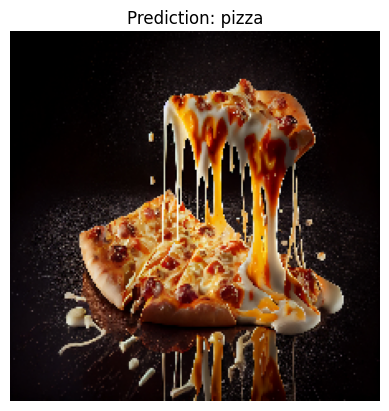

In [25]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-image-3/test_image_3.jpg', class_names)

1/1 [==============================] - 0s 25ms/step


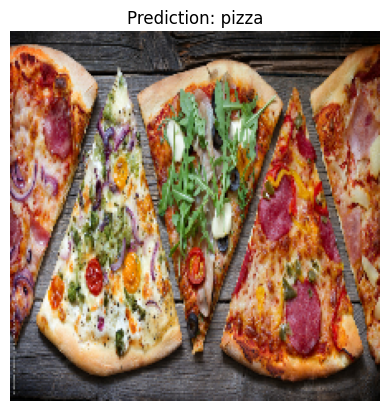

In [26]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-image-4/AdobeStock_229732806_Preview.jpeg', class_names)

1/1 [==============================] - 0s 25ms/step


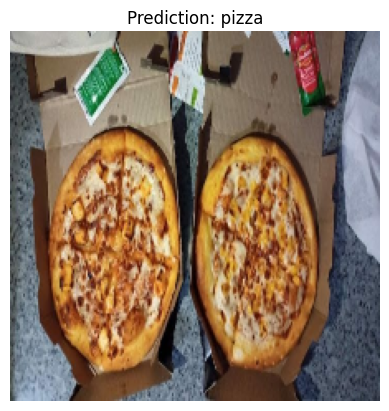

In [27]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-images-5/WhatsApp Image 2023-12-25 at 18.38.31_2370ef20.jpg', class_names)

1/1 [==============================] - 0s 25ms/step


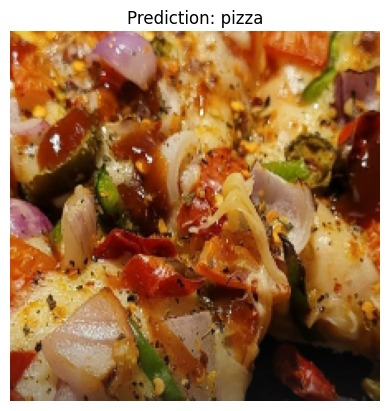

In [28]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-images-5/WhatsApp Image 2023-12-25 at 18.38.32_47e5520b.jpg', class_names)

1/1 [==============================] - 0s 24ms/step


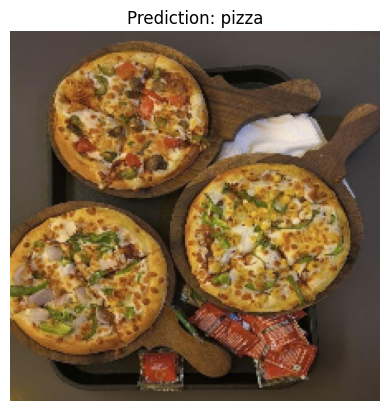

In [29]:
pred_and_plot(feature_extractor_model, '/kaggle/input/test-images-5/WhatsApp Image 2023-12-25 at 18.38.33_891a010c.jpg', class_names)